```
Licensed under the Apache License, Version 2.0 (the "License");
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Aggregating Nested Transformer

https://arxiv.org/pdf/2105.12723.pdf

This colab shows how to 

- check data pipelines
- load pretrained checkpoints for inference 
- train CIFAR for steps

## Setup

In [1]:
![ -d nested-transformer ] || git clone --depth=1 https://github.com/google-research/nested-transformer
!cd nested-transformer && git pull

Already up to date.


In [2]:
!pip install -qr nested-transformer/requirements.txt

### (Optional) Connect to TPU

Set Colab: Runtime -> Change runtime type -> TPU

In [3]:
USE_TPU = False

if USE_TPU:
  # Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
  # cannot see the TPUs because they're not directly attached. Instead we need to
  # setup JAX to communicate with a second machine that has the TPUs attached.
  import os
  if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
    import jax
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print('Connected to TPU.')
  else:
    print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

## Import

In [4]:
import sys
sys.path.append('./nested-transformer')

import os
import time
import flax
from flax import nn
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import functools
from absl import logging


from libml import input_pipeline 
from libml import preprocess
from models import nest_net  
import train  
from configs import cifar_nest 
from configs import imagenet_nest  

# Hide any GPUs form TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")
logging.set_verbosity(logging.INFO)

print("JAX devices:\n" + "\n".join([repr(d) for d in jax.devices()]))
print('Current folder content', os.listdir())

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


JAX devices:
CpuDevice(id=0)
Current folder content ['.config', 'nested-transformer', 'dog.jpg', 'sample_data']


## ImageNet

### Download checkpoints and load model

In [5]:
checkpoint_dir = "./nested-transformer/checkpoints/"
remote_checkpoint_dir = "gs://gresearch/nest-checkpoints/nest-b_imagenet"
print('List checkpoints: ')
!gsutil ls "$remote_checkpoint_dir"

List checkpoints: 
gs://gresearch/nest-checkpoints/nest-b_imagenet/checkpoint
gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.data-00000-of-00001
gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.flax
gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.index


In [6]:
print('Download checkpoints: ')
!mkdir -p "$checkpoint_dir"
!gsutil cp -r "$remote_checkpoint_dir" "$checkpoint_dir".

Download checkpoints: 
Copying gs://gresearch/nest-checkpoints/nest-b_imagenet/checkpoint...
Copying gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.data-00000-of-00001...
Copying gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.flax...
Copying gs://gresearch/nest-checkpoints/nest-b_imagenet/ckpt-39.index...
/ [4 files][775.1 MiB/775.1 MiB]   65.3 MiB/s                                   
Operation completed over 4 objects/775.1 MiB.                                    


In [7]:
# Use checkpoint of host 0.
imagenet_config = imagenet_nest.get_config()

state_dict = train.checkpoint.load_state_dict(
    os.path.join(checkpoint_dir, os.path.basename(remote_checkpoint_dir)))
variables = {
    "params": state_dict["optimizer"]["target"],
}
variables.update(state_dict["model_state"])
model_cls = nest_net.create_model(imagenet_config.model_name, imagenet_config)
model = functools.partial(model_cls, num_classes=1000)

INFO:absl:load_state_dict ...
INFO:absl:load_state_dict finished after 2.11s.


### Inference on a single image

--2021-06-19 00:24:02--  https://picsum.photos/id/237/200/300
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.5.30, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/237/200/300.jpg?hmac=TmmQSbShHz9CdQm0NkEjx1Dyh_Y984R9LpNrpvH2D_U [following]
--2021-06-19 00:24:02--  https://i.picsum.photos/id/237/200/300.jpg?hmac=TmmQSbShHz9CdQm0NkEjx1Dyh_Y984R9LpNrpvH2D_U
Resolving i.picsum.photos (i.picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11531 (11K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  11.26K  --.-KB/s    in 0s      

2021-06-19 00:24:02 (72.3 MB/s) - ‘dog.jpg’ saved [11531/11531]



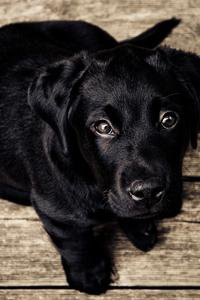

In [9]:
import PIL

!wget https://picsum.photos/id/237/200/300 -O dog.jpg
img = PIL.Image.open('dog.jpg')
img

In [10]:
def predict(image):
  logits = model(train=False).apply(variables, image, mutable=False)
  # Return predicted class and confidence.
  return logits.argmax(axis=-1), nn.softmax(logits, axis=-1).max(axis=-1)

def _preprocess(image):
  image = np.array(image.resize((224, 224))).astype(np.float32) / 255
  mean = np.array(preprocess.IMAGENET_DEFAULT_MEAN).reshape(1, 1, 3)
  std = np.array(preprocess.IMAGENET_DEFAULT_STD).reshape(1, 1, 3)
  image = (image - mean) / std
  return image[np.newaxis,...]

input = _preprocess(img)

cls, prob = predict(input)
print(f'ImageNet class id: {cls[0]}, prob: {prob[0]}')

ImageNet class id: 208, prob: 0.8865696787834167


## CIFAR

### Inspect input pipeline of CIFAR

Use the cifar image augmentations

In [11]:
cifar_builder = tfds.builder("cifar10")

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmp4sb0m419tfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.


INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmplmtmz7xctfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.3a777a74bc5e4505a39ec7a55d4a7649...


INFO:absl:Done writing cifar10-train.tfrecord. Number of examples: 50000 (shards: [50000])


INFO:absl:Done writing cifar10-test.tfrecord. Number of examples: 10000 (shards: [10000])
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:356: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:369: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
INFO:absl:Configure augmentation type randaugment
INFO:absl:Using augmentation randaugment with parameters {'cutout': False, 'magnitude': 9, 'magstd': 0.5, 'num_layers': 2, 'prob_to_apply': 0.5, 'size': 32}


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Constructing tf.data.Dataset cifar10 for split ReadInstruction([_RelativeInstruction(splitname='train', from_=0, to=50000, unit='abs', rounding='closest')]), from /root/tensorflow_datasets/cifar10/3.0.2


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ReadInstruction([_RelativeInstruction(splitname='test', from_=0, to=10000, unit='abs', rounding='closest')]), from /root/tensorflow_datasets/cifar10/3.0.2


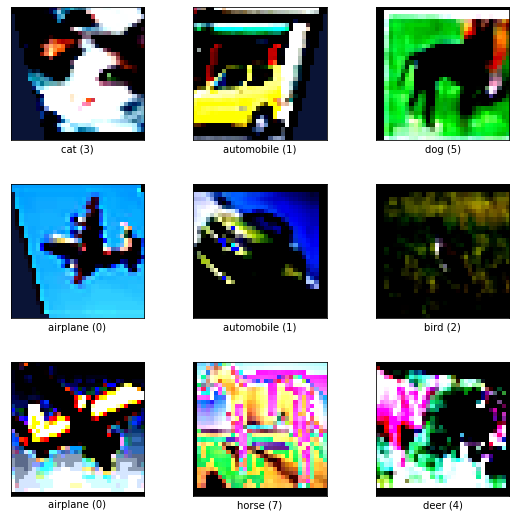

In [12]:
config = cifar_nest.get_config()
# Do not apply MixUp or CutMix operations since tfds.visualization.show_examples 
# only accepts integer labels
config.mix = None 

info, train_ds, eval_ds = input_pipeline.create_datasets(
    config, jax.random.PRNGKey(0)
)
_ = tfds.visualization.show_examples(train_ds.unbatch().unbatch(), cifar_builder.info)

### Running a single training step on CIFAR


In [13]:
config = cifar_nest.get_config()
config.num_train_steps = 1
config.num_eval_steps = 1
config.num_epochs = 1
config.warmup_epochs = 0
config.per_device_batch_size = 128 # Set to smaller batch size to avoid OOM
workdir = f"./nested-transformer/checkpoints/cifar_nest_colab_{int(time.time())}"

In [14]:
# Re-create datasets with possibly updated config.
info, train_ds, eval_ds = input_pipeline.create_datasets(
    config, jax.random.PRNGKey(0)
)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:356: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:369: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
INFO:absl:Configure augmentation type randaugment
INFO:absl:Using augmentation randaugment with parameters {'cutout': False, 'magnitude': 9, 'magstd': 0.5, 'num_layers': 2, 'prob_to_apply': 0.5, 'size': 32}
INFO:absl:Configure mix augmentation type {mixup_alpha: 0.8, prob_to_apply: 1.0, smoothing: 0.1}

INFO:absl:Construc

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead
INFO:absl:Constructing tf.data.Dataset cifar10 for split ReadInstruction([_RelativeInstruction(splitname='test', from_=0, to=10000, unit='abs', rounding='closest')]), from /root/tensorflow_datasets/cifar10/3.0.2


In [15]:
train.train_and_evaluate(config, workdir)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:356: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:369: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
INFO:absl:Configure augmentation type randaugment
INFO:absl:Using augmentation randaugment with parameters {'cutout': False, 'magnitude': 9, 'magstd': 0.5, 'num_layers': 2, 'prob_to_apply': 0.5, 'size': 32}
INFO:absl:Configure mix augmentation type {mixup_alpha: 0.8, prob_to_apply: 1.0, smoothing: 0.1}

INFO:absl:Construc